### **Laboratorio 6 - Deep Learning**
Stefano Aragoni, Carol Arévalo

----------------


#### Análisis Exploratorio de Datos

Sistema de recomendación para libros utilizando el siguiente dataset:

- Books.csv – Datos de 270k libros
- Users.csv – Datos de usuario (id, location, age) (57k usuarios)
- Ratings.csv – Rating 0-10 dado por un usuario a un libro determinado. (340k ratings)

----------------

##### *Importar librerías*

Como primer paso, se importaron las librerías necesarias para el desarrollo del laboratorio.

In [290]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.cluster import KMeans
from prettytable import PrettyTable

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

-----------

##### *Cargar los Conjuntos de Datos*

Posteriormente, se cargó todos los conjuntos de datos en varios dataframes de pandas.

In [300]:
# Crear un DataFrame con el contenido de Books.csv
df_books = pd.read_csv('./archive/Books.csv')

# Crear un DataFrame con el contenido de Users.csv
df_users = pd.read_csv('./archive/Users.csv')

# Crear un DataFrame con el contenido de Ratings.csv
df_ratings = pd.read_csv('./archive/Ratings.csv')

Posteriormente, se imprimió las primeras 5 filas de cada dataframe para tener una idea de la estructura de los datos.

En el caso del dataframe de Books.csv, se observó 8 columnas. La primera ISBN, que es el identificador único de cada libro, seguido del título, autor, año de publicación, editorial, url de la portada, url de la pequeña portada y la url de la mediana portada.

En este caso, inicialmente se considera que las únicas columnas que serán de utilidad para el sistema de recomendación son el ISBN, título, autor, año de publicación y editorial. Los links de las portadas no serán de utilidad para el sistema de recomendación.

In [301]:
# Convertir variables a tipo numérico
df_books['ISBN'] = df_books['ISBN'].str.replace('X', '10')
df_books['ISBN'] = pd.to_numeric(df_books['ISBN'], errors='coerce')
df_books['Year-Of-Publication'] = pd.to_numeric(df_books['Year-Of-Publication'], errors='coerce')

print("Número de Libros: ", df_books.shape[0])

# Primeras 5 filas de df_books
df_books.head()

Número de Libros:  271360


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,195153448.00,Classical Mythology,Mark P. O. Morford,2002.00,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,2005018.00,Clara Callan,Richard Bruce Wright,2001.00,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,60973129.00,Decision in Normandy,Carlo D'Este,1991.00,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,374157065.00,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.00,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,393045218.00,The Mummies of Urumchi,E. J. W. Barber,1999.00,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [302]:
# Eliminar las columnas Image-URL-S, Image-URL-M, Image-URL-L
df_books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

Posteriormente, se observó el dataframe de Users.csv. Este contiene 3 columnas; la primera es el identificador único de cada usuario, seguido de la ubicación y la edad. 

Sin embargo, se nota que hay varios usuarios que no tienen edad, por lo que será necesario eliminarlos del dataframe. Asimismo, la columna de Location tiene ciudad,estado y país. Se plantea la posibildiad de únicamente utilizar el país, ya que la ciudad y el estado pueden aumentar la complejidad del sistema de recomendación.

In [303]:
# Convertir variables a tipo numérico
df_users['Age'] = pd.to_numeric(df_users['Age'], errors='coerce')
df_users["User-ID"] = pd.to_numeric(df_users["User-ID"], errors='coerce')

print("Número de Usuarios: ", df_users.shape[0])

# Primeras 5 filas de df_users
df_users.head()

Número de Usuarios:  278858


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.00
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.00
4,5,"farnborough, hants, united kingdom",NaN


En el caso de Ratings.csv, se observó que tiene 3 columnas; el identificador único de cada usuario, el ISBN del libro y el rating que le dio el usuario al libro.

Cabe destacar que se considera que todas estas columnas serán de utilidad para el sistema de recomendación.

In [304]:
# Convertir variables a tipo numérico
df_ratings['ISBN'] = df_ratings['ISBN'].str.replace('X', '10')
df_ratings['User-ID'] = pd.to_numeric(df_ratings['User-ID'], errors='coerce')
df_ratings['ISBN'] = pd.to_numeric(df_ratings['ISBN'], errors='coerce')
df_ratings['Book-Rating'] = pd.to_numeric(df_ratings['Book-Rating'], errors='coerce')

print("Número de Calificaciones: ", df_ratings.shape[0])

# Primeras 5 filas de df_ratings
df_ratings.head()

Número de Calificaciones:  1149780


,User-ID,ISBN,Book-Rating
0,276725,3454510410.00,0
1,276726,155061224.00,5
2,276727,446520802.00,0
3,276729,5216561510.00,3
4,276729,521795028.00,6


-----------

##### *Descripción de Variables*

Como segundo paso del análisis exploratorio, se <font color=orange>obtuvo estadísticas descriptivas básicas de las variables de los conjuntos de datos</font>.

En el caso de df_books, se puede observar que solamente hay dos variables numéricas, que son el año de publicación y el ISBN. El resto de variables son categóricas.

En el caso de estas variables, se puede observar que 50% de los lobros son del año 1995 en adelante. Por alguna razón, hay un libro que tiene el año de publicación 0; se requiere investigar más sobre este libro.

In [267]:
# Estadísticas descriptivas básicas de df_books
df_books.describe()

,ISBN,Year-Of-Publication
count,270832.00,271357.00
mean,1846809906.47,1959.76
std,5482671907.87,257.99
min,913154.00,0.00
25%,394549219.75,1989.00
50%,679847607.00,1995.00
75%,1551660354.75,2000.00
max,99975207010.00,2050.00


En el caso de df_users, se puede observar nuevamente dos variables numéricas, que son el identificador único de cada usuario y la edad. La edad promedio de los usuarios es de 34 años, con una desviación estándar de 14 años. La edad mínima es de 0 años y la máxima es de 244 años. 

Asimismo, cabe destacar que hay varios usuarios que no tienen edad, por lo que se requiere eliminarlos del dataframe.

In [268]:
# Estadísticas descriptivas básicas de df_users
df_users.describe()

,User-ID,Age
count,278858.00,168096.00
mean,139429.50,34.75
std,80499.52,14.43
min,1.00,0.00
25%,69715.25,24.00
50%,139429.50,32.00
75%,209143.75,44.00
max,278858.00,244.00


Finalmente, en df_ratings, se pueden observar tres variables numéricas, que son el identificador único de cada usuario, el ISBN del libro y el rating que le dio el usuario al libro.

En el caso de los ratings, se puede observar que el rating promedio es de 2.87. El 50% de los ratings son 0, por lo cual posiblemente se eliminará una porción de estos ratings para evitar sesgos en el sistema de recomendación.

In [269]:
# Estadísticas descriptivas básicas de df_ratings
df_ratings.describe()

,User-ID,ISBN,Book-Rating
count,1149780.00,1147157.00,1149780.00
mean,140386.40,8805272786311033856.00,2.87
std,80562.28,9430905119786851631104.00,3.85
min,2.00,0.00,0.00
25%,70345.00,380754509.00,0.00
50%,141010.00,553272837.00,0.00
75%,211028.00,872495892.00,7.00
max,278854.00,10101010101010101035859968.00,10.00


-----------

##### *Visualización de Datos*

Como tercer paso, se realizó una <font color=orange>visualización de la distribución de las variables del conjunto de datos</font>.


**DataFrame Books**

Para el caso del dataframe de libros, se realizó un histograma de la distribución de los años de publicación de los libros. Se puede observar que la mayoría de libros fueron publicados en los años 2000 en adelante. 

En el caso de ISBN, se realizó un histograma de la distribución de los ISBN. Se puede observar que la mayoría de libros tienen un ISBN de 0 a 0.15e11. 

array([[<AxesSubplot: title={'center': 'ISBN'}>,
        <AxesSubplot: title={'center': 'Year-Of-Publication'}>]],
      dtype=object)

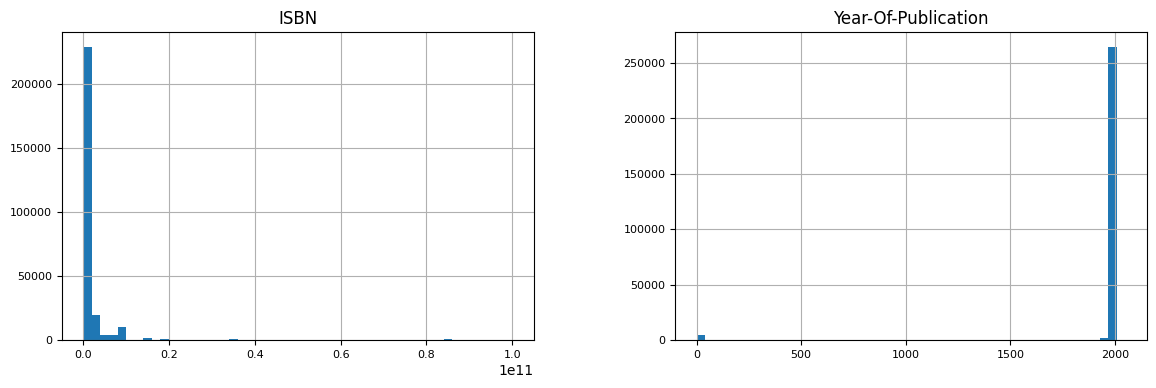

In [270]:
# Visualización de la distribución de las variables de df_books
df_books.hist(figsize=(14, 4), bins=50, xlabelsize=8, ylabelsize=8)

Al analizar el histograma de la distribución de títulos de los libros, se puede observar que hay varios títulos que se repiten; posiblemente a que hay varios libros que son parte de una serie o que son ediciones diferentes del mismo libro.

Con relación a los autores, se puede observar que hay autores con hasta 600 libros publicados. Sin embargo, la mayoría de autores tienen menos de 100 libros publicados.

Finalmente, en el caso de las editoriales, la cada editorial Harlequin tiene más de 7000 libros publicados. El segundo lugar lo tiene Silhouette con más de 4000 libros publicados. El resto de editoriales tienen menos de 2000 libros publicados.

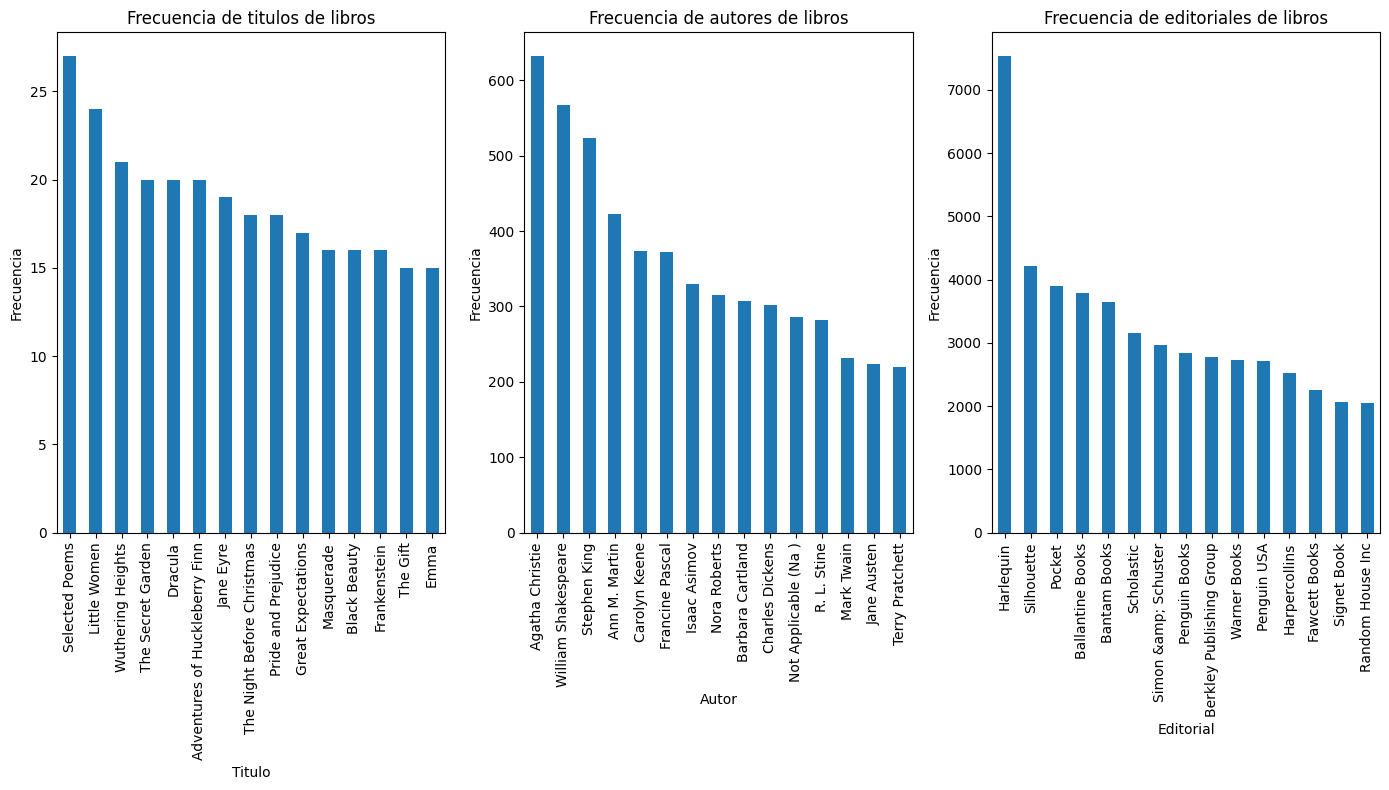

In [271]:
# Visualización de la distribución de las variables de df_users
fig, ax = plt.subplots(1, 3, figsize=(14, 8))

df_books['Book-Title'].value_counts().head(15).plot.bar(ax=ax[0])
ax[0].set_title('Frecuencia de titulos de libros')
ax[0].set_ylabel('Frecuencia')
ax[0].set_xlabel('Titulo')

df_books['Book-Author'].value_counts().head(15).plot.bar(ax=ax[1])
ax[1].set_title('Frecuencia de autores de libros')
ax[1].set_ylabel('Frecuencia')
ax[1].set_xlabel('Autor')

df_books['Publisher'].value_counts().head(15).plot.bar(ax=ax[2])
ax[2].set_title('Frecuencia de editoriales de libros')
ax[2].set_ylabel('Frecuencia')
ax[2].set_xlabel('Editorial')

fig.tight_layout()


**DataFrame Users**

Con relación a los usuarios, se realizó un histograma de la distribución de las edades de los usuarios. Se puede observar que la mayoría de usuarios tienen entre 20 y 40 años.

Nuevamente, cabe destacar la presencia de usuarios con edad 0 y una persona con edad 244 años. Nuevamente, se requiere investigar más sobre estos usuarios.

array([[<AxesSubplot: title={'center': 'User-ID'}>,
        <AxesSubplot: title={'center': 'Age'}>]], dtype=object)

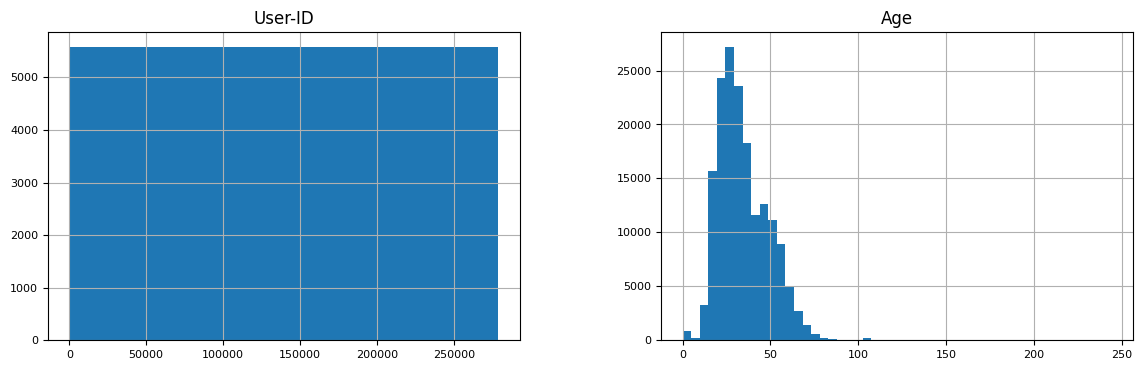

In [272]:
# Visualización de la distribución de las variables de df_users
df_users.hist(figsize=(14, 4), bins=50, xlabelsize=8, ylabelsize=8)

Al analizar la distribución de las ubicaciones de los usuarios, se puede observar que la ciudad con más usuarios es Londres, seguido de Toronto y Sydney. Cabe destacar que, a pesar de que Estados Unidos es el país con más usuarios, no hay ninguna ciudad de Estados Unidos en el top 3 de ciudades con más usuarios.

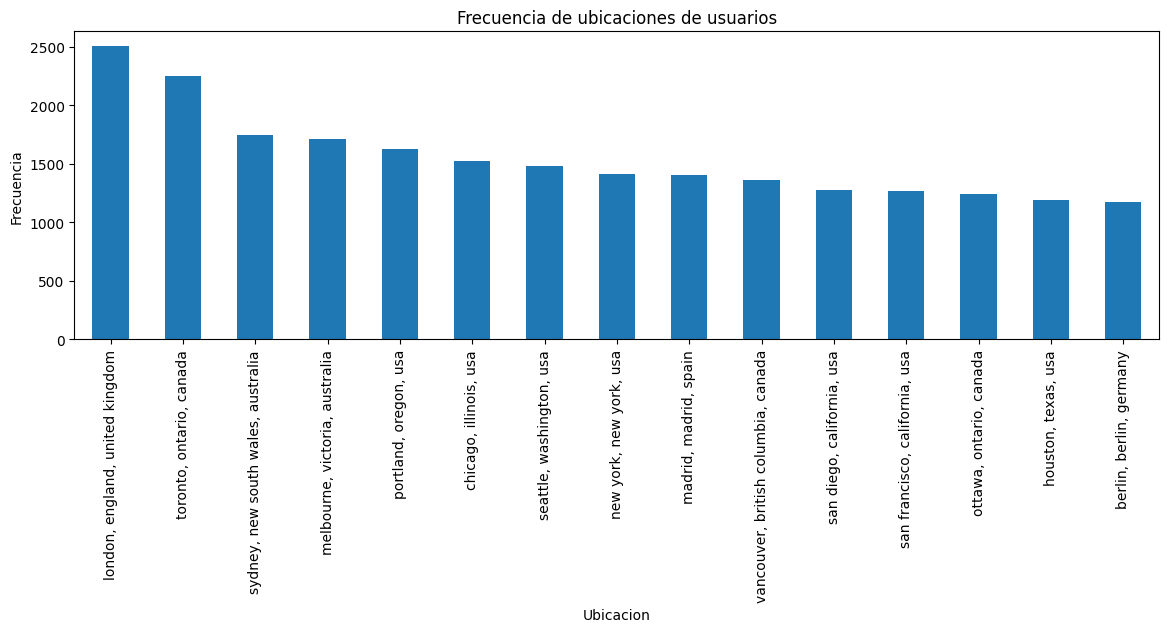

In [273]:
# Visualización de la distribución de las variables de df_users (categorica)

df_users["Location"].value_counts().head(15).plot.bar(figsize=(14, 4))
plt.title("Frecuencia de ubicaciones de usuarios")
plt.xlabel("Ubicacion")
plt.ylabel("Frecuencia")

plt.show()


**DataFrame Raitings**

En el caso de los ratings, se realizó un histograma de la distribución de los ratings. Se puede observar que la mayoría de ratings son 0, seguido de 8 y 10. 

Sin embargo, se considera que los ratings de 0 pueden sesgar el sistema de recomendación, por lo que posiblemente se eliminarán estos ratings. Esto especialmente considerando que la mayoría de ratings son 0; posiblemente más de 60% de los ratings son 0.


Asimismo, cabe destacar que no hay muchas calificaciones de 1 a 7, por lo que también se considera necesario balancear los ratings.

array([[<AxesSubplot: title={'center': 'User-ID'}>,
        <AxesSubplot: title={'center': 'ISBN'}>],
       [<AxesSubplot: title={'center': 'Book-Rating'}>, <AxesSubplot: >]],
      dtype=object)

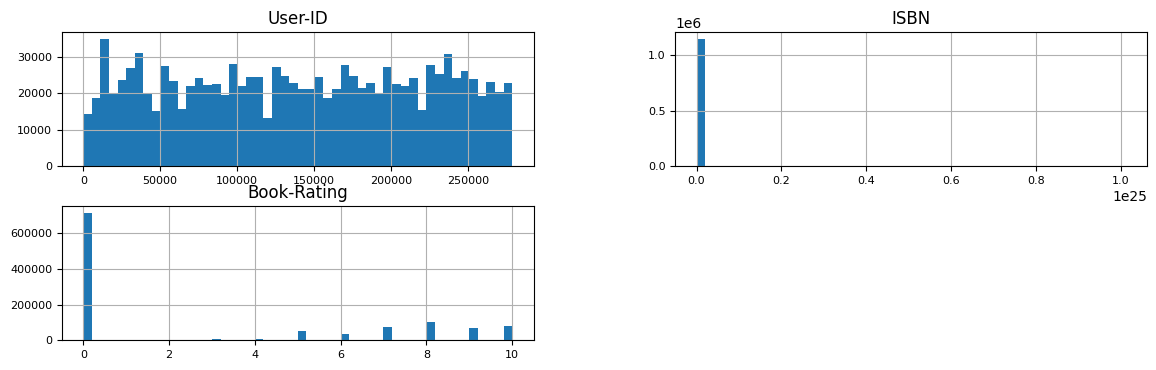

In [274]:
# Visualización de la distribución de las variables de df_ratings
df_ratings.hist(figsize=(14, 4), bins=50, xlabelsize=8, ylabelsize=8)

-----------

##### *Valores Atípicos*

Como cuarto paso, se <font color=orange>identificaron y analizaron los valores atípicos</font> de los conjuntos de datos.

**DataFrame Users**

Inicialmente se pensó que únicamente había un usuario con 244 años. Sin embargo, al analizar el dataframe, se puede observar que hay varios usuarios con más de 100 años. Sin embargo, ninguna persona ha vivido más de 150 años; mucho menos 244 años. Por lo tanto, se considera que estos valores son erróneos.

En la sección de limpieza de datos, se eliminarán estos usuarios.

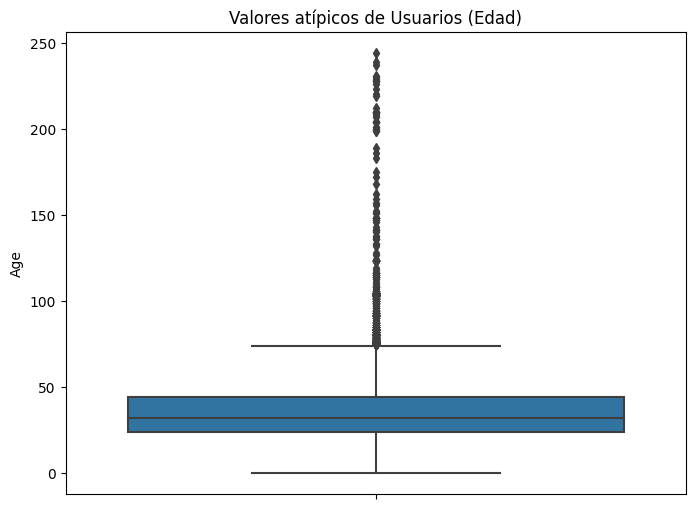

In [275]:
# Valores atípicos de Usuarios (Edad)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_users, y='Age')
plt.title('Valores atípicos de Usuarios (Edad)')
plt.show()

**DataFrame Books**

En el caso de los libros, en las primeras fases del análisis exploratorio de datos, se observó la presencia de uno (o más libros) con año de publicación 0.

Al analizar la distribución de los años de publicación en un gráfico de caja, nuevaente se observa la presencia de libros con año de publicación 0. Asimismo, existen unos libros publicados cerca del año 1400. 


Se considera que los libros del año 0 son erróneos, por lo que se eliminarán en la sección de limpieza de datos. Sin embargo, no se eliminarán los libros del año 1400, ya que es posible que estos libros sean libros antiguos que fueron digitalizados.

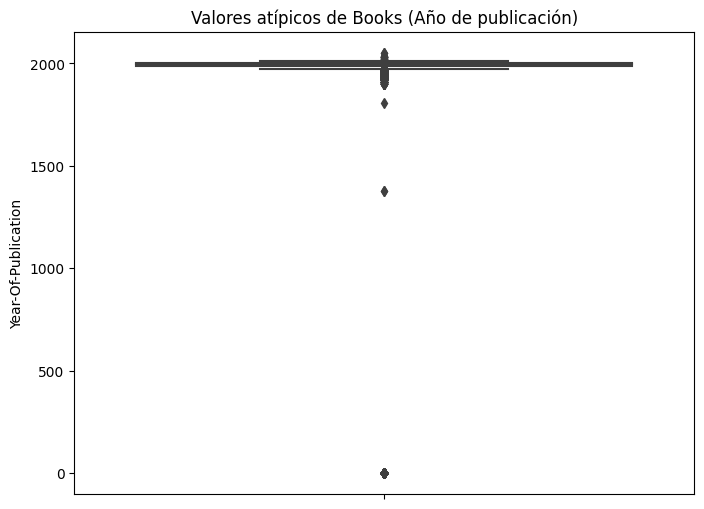

In [276]:
# Valores atípicos de Books (Año de publicación)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_books, y='Year-Of-Publication')
plt.title('Valores atípicos de Books (Año de publicación)')
plt.show()

-----------
##### *Datos Faltantes*

Posteriormente, se <font color=orange>identificaron y analizaron los datos faltantes</font> de los conjuntos de datos.

Como se puede observar a continuación, df_books presenta un libro sin ISBN. Por otro lado, df_users presenta varios usuarios sin edad; posiblemente casi la mitad de los usuarios no tienen edad. Finalmente, df_ratings presenta unas raitings sin ISBN del libro. 

Para reducir la complejidad del sistema de recomendación, se considera que únicamente se utilizarán los libros que tengan ISBN. Por lo tanto, se eliminará el libro sin ISBN del dataframe de libros. Asimismo, se eliminarán los usuarios sin edad del dataframe de usuarios.

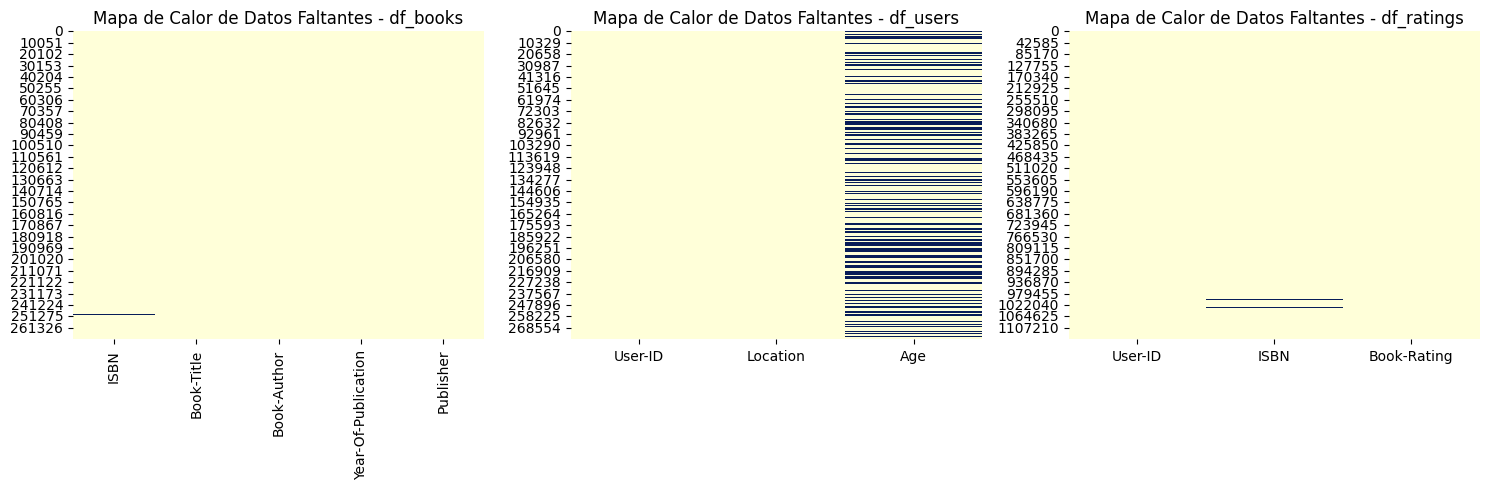

In [277]:
# Crear un mapa de calor de datos faltantes
dataframes = [df_books, df_users, df_ratings]
titles = ['df_books', 'df_users', 'df_ratings']

plt.figure(figsize=(15, 5))

for i, df in enumerate(dataframes):
    plt.subplot(1, 3, i + 1)
    sns.heatmap(df.isnull(), cbar=False, cmap='YlGnBu')
    plt.title(f'Mapa de Calor de Datos Faltantes - {titles[i]}')

plt.tight_layout()
plt.show()

-----------

##### *Relación entre Variables*

Como último paso previo a la limpieza de datos, se <font color=orange>analizó la relación entre las variables</font> de los conjuntos de datos.

Para esto, como primer paso, se combinaron los dataframes de libros, usuarios y ratings en un solo dataframe. Posteriormente, se analizó la correlación entre las variables del dataframe.

In [278]:
# Combinar los DataFrames df_ratings, df_books y df_users
ratings_with_users = df_ratings.merge(df_users, on='User-ID', how='inner')
final_ratings = ratings_with_users.merge(df_books, on='ISBN', how='inner')

final_ratings = final_ratings[['User-ID', 'Location', 'Age', 'ISBN', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Book-Rating']]

final_ratings.head()

,User-ID,Location,Age,ISBN,Book-Author,Year-Of-Publication,Publisher,Book-Rating
0,276725,"tyler, texas, usa",NaN,3454510410.00,M. J. Rose,2002.00,Ballantine Books,0
1,2313,"cincinnati, ohio, usa",23.00,3454510410.00,M. J. Rose,2002.00,Ballantine Books,5
2,6543,"strafford, missouri, usa",34.00,3454510410.00,M. J. Rose,2002.00,Ballantine Books,0
3,8680,"st. charles county, missouri, usa",2.00,3454510410.00,M. J. Rose,2002.00,Ballantine Books,5
4,10314,"beaverton, oregon, usa",NaN,3454510410.00,M. J. Rose,2002.00,Ballantine Books,9


Posteriormente, se realizó un proceso de one-hot encoding para convertir las variables categóricas en variables numéricas. Posteriormente, se analizó la correlación entre las variables del dataframe.

In [279]:
# Encoding de variables categóricas
final_ratings['Book-Author'] = final_ratings['Book-Author'].astype('category').cat.codes
final_ratings['Publisher'] = final_ratings['Publisher'].astype('category').cat.codes
final_ratings['Location'] = final_ratings['Location'].astype('category').cat.codes

# Primeras 5 filas de final_ratings
final_ratings.head()

,User-ID,Location,Age,ISBN,Book-Author,Year-Of-Publication,Publisher,Book-Rating
0,276725,20423,NaN,3454510410.00,61682,2002.00,1388,0
1,2313,4098,23.00,3454510410.00,61682,2002.00,1388,5
2,6543,19353,34.00,3454510410.00,61682,2002.00,1388,0
3,8680,18986,2.00,3454510410.00,61682,2002.00,1388,5
4,10314,1649,NaN,3454510410.00,61682,2002.00,1388,9


En este caso, se puede observar que la correlación lineal entre las variables es muy baja. Por lo tanto, se considera que no es necesario eliminar ninguna variable por correlación.

Se espera que, al entrenar a las redes neuronales, estas puedan detecctar y aprender las relaciones no lineales entre las variables.

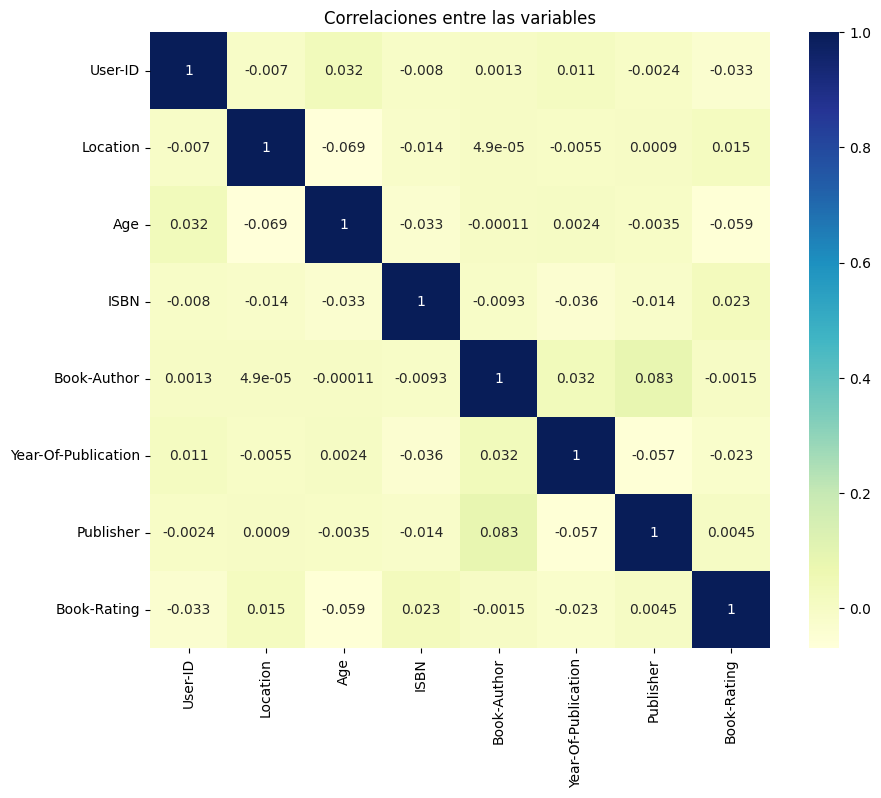

In [280]:
# Determinar correlaciones entre las variables
plt.figure(figsize=(10, 8))
sns.heatmap(final_ratings.corr(), annot=True, cmap='YlGnBu')
plt.title('Correlaciones entre las variables')
plt.show()

--------------

-----------

##### *Limpieza de Datos*

Posterior al Análisis Exploratorio de Datos, se procedió a realizar la limpieza de datos.

Anteriormente se logró detectar que existen varios problemas con los datos, como datos faltantes, datos erróneos y datos que no serán de utilidad para el sistema de recomendación. Por tal razón, se procedió a realizar la limpieza de datos.

Como primer paso, se eliminaron aquellas filas con datos nulos. Esto debido a que anteriormente se determinó una gran cantidad de valores nulos (o 0) en la edad de los usuarios, por lo que se procedió a eliminarlos. Asimismo, también se eliminaron los libros sin ISBN.

In [281]:
# Eliminar filas que tengan valores nulos o 0 en Age
final_ratings = final_ratings[final_ratings['Age'] != 0]
final_ratings = final_ratings.dropna()

final_ratings.head()

,User-ID,Location,Age,ISBN,Book-Author,Year-Of-Publication,Publisher,Book-Rating
1,2313,4098,23.00,3454510410.00,61682,2002.00,1388,5
2,6543,19353,34.00,3454510410.00,61682,2002.00,1388,0
3,8680,18986,2.00,3454510410.00,61682,2002.00,1388,5
5,23768,19043,45.00,3454510410.00,61682,2002.00,1388,0
7,28523,18855,24.00,3454510410.00,61682,2002.00,1388,0


Posteriormente, se eliminaron las filas con datos atípicos. En este caso, se eliminaron los usuarios con edad mayor a 100 años, ya que se considera que estos datos son erróneos. Asimismo, se eliminaron los libros con año de publicación 0, ya que se considera que estos datos son erróneos.

In [282]:
# Eliminar datos atípicos
final_ratings = final_ratings[final_ratings['Age'] < 100]
final_ratings = final_ratings[final_ratings['Age'] > 5]
final_ratings = final_ratings[final_ratings['Year-Of-Publication'] > 1300]

final_ratings.head()

,User-ID,Location,Age,ISBN,Book-Author,Year-Of-Publication,Publisher,Book-Rating
1,2313,4098,23.00,3454510410.00,61682,2002.00,1388,5
2,6543,19353,34.00,3454510410.00,61682,2002.00,1388,0
5,23768,19043,45.00,3454510410.00,61682,2002.00,1388,0
7,28523,18855,24.00,3454510410.00,61682,2002.00,1388,0
10,56157,6749,36.00,3454510410.00,61682,2002.00,1388,0


Asimismo, se decidió eliminar las 90% de las filas con ratings 0. Esto debido a que se considera que estos ratings pueden sesgar el sistema de recomendación. Esto especialmente considerando que más de 60% de los ratings son 0.

In [283]:
# Eliminar el 90% de las filas con Book-Rating = 0
num_rows_to_keep = int(0.1 * len(final_ratings[final_ratings['Book-Rating'] == 0]))
zero_rating_rows = final_ratings[final_ratings['Book-Rating'] == 0]
non_zero_rating_rows = final_ratings[final_ratings['Book-Rating'] != 0]
zero_rating_sample = zero_rating_rows.sample(n=num_rows_to_keep, random_state=42)

final_ratings = pd.concat([zero_rating_sample, non_zero_rating_rows])
final_ratings = final_ratings.sample(frac=1, random_state=42)  

# Proporción de valores de la variable Book-Rating
final_ratings['Book-Rating'].value_counts()

8     63326
10    52934
0     47424
7     44473
9     44315
5     27116
6     20954
4      4966
3      3243
2      1514
1       854
Name: Book-Rating, dtype: int64

Finalmente, se quiso verificar que ya no existan datos nulos en el dataframe. Como se puede observar, ya no existen datos nulos en el dataframe.

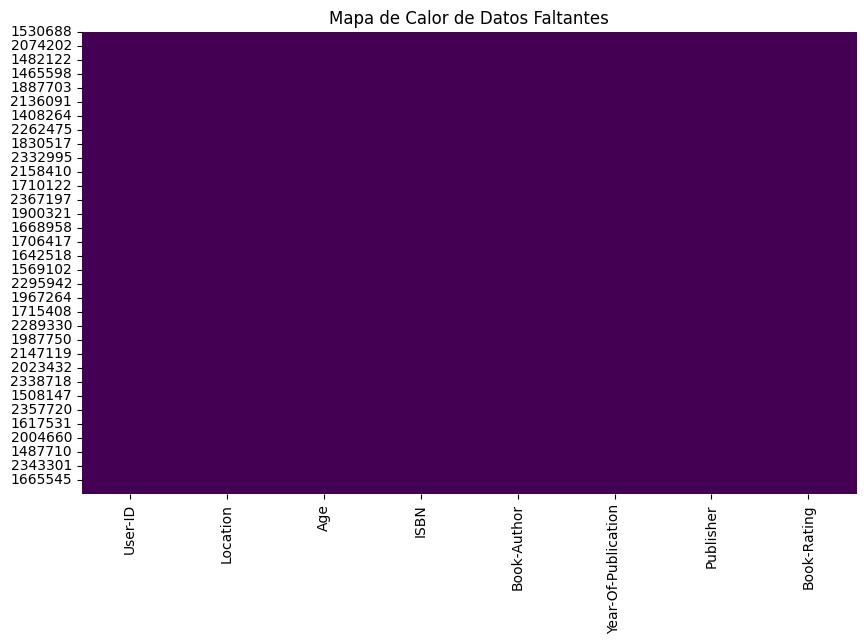

In [284]:
# Crear un mapa de calor de datos faltantes
plt.figure(figsize=(10, 6))
sns.heatmap(final_ratings.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de Calor de Datos Faltantes')
plt.show()

-----------

##### *Agrupación de Datos*

Finalmente, para realizar el modelo de Recomendación basado en Filtros Colaborativos, se necesita agrupar a los usuarios por grupos. Esto es importante, ya que se asume que los usuarios de un mismo grupo tendrán gustos similares.

Las características utilizadas para la agrupación fueron:
- Año promedio de publicación de los libros leídos
- Promedio de calificaciones dadas

Esto debido a que se considera que los usuarios que leen libros publicados en años similares, probablemente tienen gustos similares. Asimismo, se considera que los usuarios siguen un patrón de calificaciones. Si siempre califican los libros con calificaciones altas, probablemente siempre calificarán los libros con calificaciones altas.

Como primer paso, se tuvo que agregar una nueva columna que almacene el año promedio de publicación de los libros que ha calificado el usuario. Asimismo, se agregó una nueva columna que almacene el promedio de calificaciones que ha dado el usuario.

In [285]:
# Calcular el año promedio de los libros que leyó cada usuario
average_year = final_ratings.groupby('User-ID')['Year-Of-Publication'].mean()
average_year = pd.DataFrame(average_year)
average_year.columns = ['Average-Year']

# Calcular la nota promedio que da un usuario
average_rating = final_ratings.groupby('User-ID')['Book-Rating'].mean()
average_rating = pd.DataFrame(average_rating)
average_rating.columns = ['Average-Rating']

# Hacer que average_rating sea INT
average_rating = average_rating.astype('int')
# Hacer que average_year sea INT
average_year = average_year.astype('int')

# Combinar average_year con final_ratings
final_ratings = final_ratings.merge(average_year, on='User-ID', how='inner')

# Combinar average_rating con final_ratings
final_ratings = final_ratings.merge(average_rating, on='User-ID', how='inner')

final_ratings.head()

,User-ID,Location,Age,ISBN,Book-Author,Year-Of-Publication,Publisher,Book-Rating,Average-Year,Average-Rating
0,248805,5290,34.00,425118703.00,21432,1995.00,1714,9,1992,6
1,248805,5290,34.00,451179285.00,90803,1994.00,10280,10,1992,6
2,248805,5290,34.00,553279378.00,62076,1983.00,1414,10,1992,6
3,248805,5290,34.00,805059628.00,77933,1999.00,6903,9,1992,6
4,248805,5290,34.00,671832174.00,98820,1979.00,11710,0,1992,6


La agrupación se realizó utilizando el algoritmo K-Means. Se decidió utilizar este algoritmo debido a que es un algoritmo de aprendizaje no supervisado que permite agrupar a los usuarios en grupos basados en sus características.

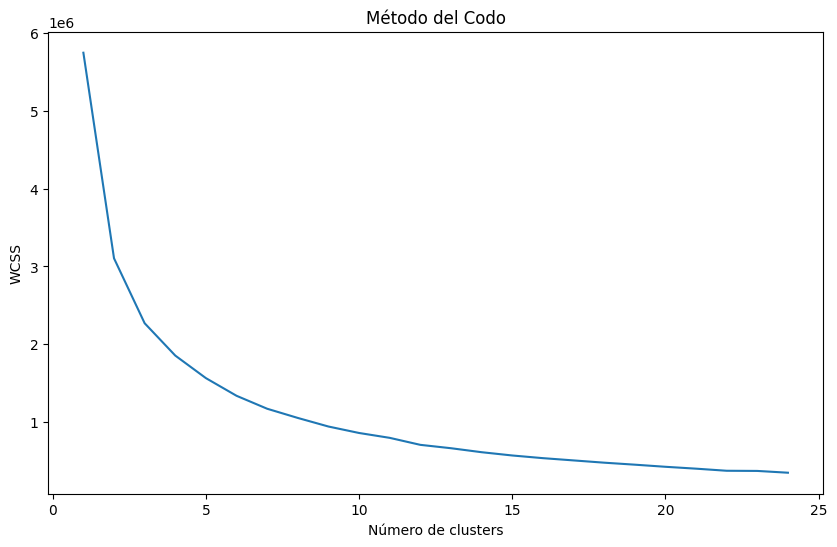

In [286]:
# Codo para determinar el número óptimo de clusters
X = final_ratings[['Average-Year', 'Average-Rating']]

wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 25), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

In [288]:
# Selecciona las características para la agrupación
features = final_ratings[['Average-Year', 'Average-Rating']]
# Cantidad de grupos a crear            según el codo, el número óptimo de clusters es 7
k = 7

# Aplica un algoritmo de clustering
kmeans = KMeans(n_clusters=k, random_state=42)
final_ratings['User-Group'] = kmeans.fit_predict(features)


final_ratings.head()

,User-ID,Location,Age,ISBN,Book-Author,Year-Of-Publication,Publisher,Book-Rating,Average-Year,Average-Rating,User-Group
0,248805,5290,34.00,425118703.00,21432,1995.00,1714,9,1992,6,0
1,248805,5290,34.00,451179285.00,90803,1994.00,10280,10,1992,6,0
2,248805,5290,34.00,553279378.00,62076,1983.00,1414,10,1992,6,0
3,248805,5290,34.00,805059628.00,77933,1999.00,6903,9,1992,6,0
4,248805,5290,34.00,671832174.00,98820,1979.00,11710,0,1992,6,0


Finalmente, se guardó el dataframe de usuarios con su respectivo grupo. Esto para su posterior uso en el modelo de Recomendación Basado en Filtros Colaborativos y Basado en Contenido.

In [289]:
# Guardar el DataFrame final_ratings en un archivo CSV

# Droppear Average-Year y Average-Rating
final_ratings.drop(['Average-Year', 'Average-Rating'], axis=1, inplace=True)

final_ratings.to_csv('./archive/final_ratings.csv', index=False)